### Compare with actual transfermarkt's estimates

Here we compare our result with one got with actual transfermarkt's estimates

### Prepare

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.tabular import *

In [3]:
from fastai import tabular

In [4]:
from exp.nb_ import *

In [5]:
path=Path('../data/football/')

In [6]:
train_df = pd.read_pickle(path/'trans_over_1000_final.pkl')

In [7]:
cat_vars_tpl = ('season','trs_year','trs_month','trs_day','trs_till_deadline',
            'contract_left_months', 'contract_left_years','age',
            'is_midseason','is_loan','is_end_of_loan',
            'nat_national_name','plr_position_main',
            'plr_other_positions','plr_nationality_name',
            'plr_other_nationality_name','plr_place_of_birth_country_name',
            'plr_foot','plr_height','plr_player_agent','from_club_name','from_club_is_first_team',
            'from_clb_place','from_clb_qualified_to','from_clb_is_champion','from_clb_is_cup_winner',
            'from_clb_is_promoted','from_clb_lg_name','from_clb_lg_country','from_clb_lg_group',
            'from_coach_name', 'from_sport_dir_name',
            'to_club_name','to_club_is_first_team','to_clb_place','to_clb_qualified_to',
            'to_clb_is_champion','to_clb_is_cup_winner','to_clb_is_promoted','to_clb_lg_name','to_clb_lg_country',
            'to_clb_lg_group','to_coach_name', 'to_sport_dir_name',
            'plr_position_0','plr_position_1','plr_position_2',
            'stats_leag_name_0','stats_leag_grp_0','stats_leag_name_1','stats_leag_grp_1','stats_leag_name_2',
            'stats_leag_grp_2')
cont_vars_tpl = ('nat_months_from_debut','nat_matches_played','nat_goals_scored','from_clb_pts_avg',
             'from_clb_goals_diff_avg','to_clb_pts_avg','to_clb_goals_diff_avg','plr_apps_0',
             'plr_apps_1','plr_apps_2','stats_made_goals_0','stats_conc_gols_0','stats_cards_0',
             'stats_minutes_0','stats_team_points_0','stats_made_goals_1','stats_conc_gols_1',
             'stats_cards_1','stats_minutes_1','stats_team_points_1','stats_made_goals_2',
             'stats_conc_gols_2','stats_cards_2','stats_minutes_2','stats_team_points_2', 'pop_log1p')

In [8]:
cat_vars = list(cat_vars_tpl)
cont_vars = list(cont_vars_tpl)
all_vars = cat_vars + cont_vars

In [9]:
dep_var = 'fee'

In [10]:
df = train_df[all_vars + [dep_var]].copy()

In [11]:
np.random.seed(1001)
ln = len(df)
valid_idx = np.random.choice(ln, int(ln*0.2), replace=False)

In [12]:
procs=[FillMissing, Categorify, Normalize]

In [13]:
min_log_y = np.log(500)
max_log_y = np.log(np.max(df[dep_var])*1.2)
y_range = torch.tensor([min_log_y, max_log_y], device=defaults.device)

In [14]:
BS = 128

In [15]:
def emb_sz_rule_reduced(n_cat:int)->int: return min(10, round(1.6 * n_cat**0.56))

In [16]:
#monkey pacth embenning rule as 600 floats is too much for our case
tabular.data.emb_sz_rule = emb_sz_rule_reduced

In [17]:
name = 'w_pop_ref-346-median'

In [18]:
p = ld_var(name=f'{name}_hypers', path=path)
p

{'layers': [1000, 500],
 'layers_drop': [0.07, 0.7],
 'emb_drop': 0.7,
 'cycles': 40,
 'w_decay': 0.7,
 'max_lr': 0.001}

In [19]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
        .split_by_idx(valid_idx)
        .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
        .databunch(bs=BS))

In [20]:
np.random.seed(1001)
learn = tabular_learner(data, 
                        layers=p['layers'], 
                        ps=p['layers_drop'], 
                        emb_drop=p['emb_drop'], 
                        y_range=y_range, 
                        metrics=exp_mmape,
                        loss_func=MAELossFlat())

In [21]:
learn = learn.load(f'{name}')

In [22]:
exp_mmape_val = learn.validate()[1]
float(exp_mmape_val)

0.35330426692962646

In [23]:
valid_df = train_df.iloc[valid_idx]

### Compare with actual transfermarkt estimates

I do understand that transfermarkt's Market Value is conceptually not exactly what particular club will pay in a particular situation, but it is the best alternative here.

So It would be interestiong to compare accuracy of these predictions

In order to make comparisson fair, we have to take log of variables as we processed them this way in our model

In [172]:
actuals_l = np.array(np.log1p(valid_df['fee']))

In [173]:
tm_preds_l =  np.array(np.log1p(valid_df['market_value']))

In [174]:
model_preds_l = get_cust_preds(df=valid_df, learn=learn).T[0]

Some of transfermarkt's predictions are not avaliable, so we get rid of it in every sequence in the name of fairness

In [175]:
nan_idx = np.argwhere(np.isnan(tm_preds_l))
len(nan_idx)
correct_idx = list_diff(range(0,len(actuals_l)), list(nan_idx.T[0]))

In [176]:
actuals_l = actuals_l[correct_idx]
tm_preds_l = tm_preds_l[correct_idx]
model_preds_l = model_preds_l[correct_idx]

In [177]:
def get_error(pred, targ):
    acc = exp_mmape(pred=tensor(pred).double(), targ=tensor(targ).double())
    return int(float(acc)*100)

In [178]:
tm_error = get_error(pred=tm_preds_l, targ=actuals_l)
model_error = get_error(pred=model_preds_l, targ=actuals_l)

In [179]:
results = {'transfermarkt':tm_error, 'model':model_error}
results

{'transfermarkt': 37, 'model': 35}

In [180]:
results = pd.DataFrame(results, index=['error'])

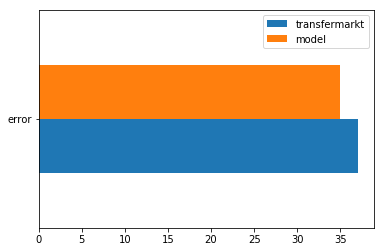

In [181]:
results.plot.barh()

Hm... that's not good my model cannot be better than transfermarkt's

Oh, I know let's also get rig of loans, as tm is not meant to predict it right

In [182]:
len(valid_df), len(valid_df.query('is_loan == False'))

(1952, 1890)

In [183]:
valid_df_no_loans = valid_df.query('is_loan == False')

In [184]:
actuals_l = np.array(np.log1p(valid_df_no_loans['fee']))

In [185]:
tm_preds_l =  np.array(np.log1p(valid_df_no_loans['market_value']))

In [186]:
model_preds_l = get_cust_preds(df=valid_df_no_loans, learn=learn).T[0]

In [188]:
nan_idx = np.argwhere(np.isnan(tm_preds_l))
correct_idx = list_diff(range(0,len(actuals_l)), list(nan_idx.T[0]))
len(nan_idx)

347

In [189]:
actuals_l = actuals_l[correct_idx]
tm_preds_l = tm_preds_l[correct_idx]
model_preds_l = model_preds_l[correct_idx]

In [190]:
tm_error = get_error(pred=tm_preds_l, targ=actuals_l)
model_error = get_error(pred=model_preds_l, targ=actuals_l)

In [191]:
results = {'transfermarkt':tm_error, 'model':model_error}
results

{'transfermarkt': 35, 'model': 35}

In [192]:
results = pd.DataFrame(results, index=['error'])

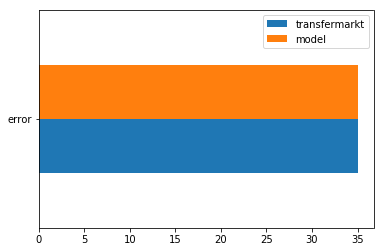

In [193]:
results.plot.barh()

Just to check manually in excel

In [251]:
to_exel = valid_df_no_loans.iloc[correct_idx].copy()
to_exel['model_preds'] = np.exp(model_preds_l)
to_exel['tm_preds'] = np.exp(tm_preds_l)
to_exel['actual'] = to_exel['fee']
to_exel['model_preds_abs_diff'] = abs(to_exel['fee'] - to_exel['model_preds'])
to_exel['tm_preds_abs_diff'] = abs(to_exel['fee'] - to_exel['tm_preds'])
to_exel['model_preds_abs_error_perc'] = abs(to_exel['fee'] - to_exel['model_preds'])/to_exel['fee']
to_exel['tm_preds_abs_error_perc'] = abs(to_exel['fee'] - to_exel['tm_preds'])/to_exel['fee']
to_exel['model_preds_abs_error_perc'].median(), to_exel['tm_preds_abs_error_perc'].median()

(0.35207781982421876, 0.3570714285714286)

In [252]:
to_exel.to_csv(path/'final.csv', sep=";")

Transfermarkt is even significantly worse. And it is powered with crowdsourcing of thousands of people.

Model result doesn't look bad, considering it knows nothing about clubs or football itself outside of limited number of features we provide. Which is a tiny fraction of information avaliable (and used by) for experts on transfermarkt.de

### Composite mode

Let's now take avarage of tranfermarkt's and model's prediction and calculate eror after that

In [245]:
comp_preds_l = (tm_preds_l + model_preds_l)/2

In [248]:
get_error(pred=tm_preds_l, targ=actuals_l)

35

In [249]:
get_error(pred=model_preds_l, targ=actuals_l)

35

In [247]:
get_error(pred=comp_preds_l, targ=actuals_l)

32

Our composite error driopped from 35% to 32%. That's good